In [ ]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
from scipy.sparse import dok_matrix
import torch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# 匯入training data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
file_path = '/content/drive/My Drive/rcv1.txt'

labels = []
rows, cols, target = [], [], []
max_index = 0

try:
    with open(file_path, 'r') as f:
        for row_index, line in enumerate(f):
            parts = line.strip().split()

            labels.append(int(parts[0]))
            #print(int(parts[0]))

            for item in parts[1:]:
                index, value = item.split(':')
                index = int(index)
                value = float(value)
                rows.append(row_index)
                cols.append(index)
                target.append(value)
                max_index = max(max_index, index)
            if row_index == 499:
                break

    n_samples = len(labels)
    n_features = max_index + 1
    sparse_matrix = dok_matrix((n_samples, n_features), dtype=np.float32)

    for r, c, v in zip(rows, cols, target):
        sparse_matrix[r, c] = v

    print(f'# of samples:  {n_samples}, # of features: {n_features}' )


except Exception as e:
    print('Loading file error : ', e)

print(labels)


# of samples:  500, # of features: 47206
[1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 

# Hyper Parameters

In [ ]:
LR = 0.1
lambda_reg = 1 / n_samples

In [ ]:
def sparse_times_dense(x, w):
    indices = x._indices()  # 稀疏張量的索引
    values = x._values()  # 稀疏張量的值

    result = 0


    for i in range(values.shape[0]):
        result += w[indices[0][i]] * values[i]

    # print(result)
    return result

# 計算Gradient, Loss

In [ ]:
def logistic_loss(X, w, y):
    loss = torch.zeros(1).to(device)
    for xi, yi in zip(X, y):
        z = sparse_times_dense(xi, w)
        loss += torch.log(1 + torch.exp(-yi * z))
    return loss / n_samples + (lambda_reg / 2) * torch.sum(w ** 2)


def single_gradient(x, w, y):
    z = sparse_times_dense(x, w)  # 單樣本的預測值

    exp_term = torch.exp(y * z)

    grad_data_loss = (-y.item() * x) / (1 + exp_term.item())
    #print((1 + exp_term.item()))

    grad_reg = lambda_reg * w
    # print(grad_reg + grad_data_loss)
    return grad_reg + grad_data_loss

def full_gradient(X, w, y):
    grad_data_loss = torch.zeros(n_features).to(device)
    for xi, yi in zip(X, y):
        z = sparse_times_dense(xi, w)
        exp_term = torch.exp(yi * z)
        grad_data_loss += (-yi.item() * xi) / (1 + exp_term.item())

    grad_reg = lambda_reg * w
    return grad_data_loss / n_samples + grad_reg

# full_gradient(X_train, w_init, y_train)

In [33]:
out_iter = 5
inner_iter = 20000
X_train = sparse_matrix
y_train = labels
coo = sparse_matrix.tocoo()

values = torch.tensor(coo.data, dtype=torch.float32)  # 非零值
indices = torch.tensor([coo.row, coo.col], dtype=torch.int64)  # 行列索引
X_train = torch.sparse_coo_tensor(indices, values, coo.shape).to(device)

y_train = torch.tensor(y_train, dtype = torch.float32).to(device)

print(y_train.shape)
losses_gama = []
effective_passes_gama = []
gama_choice = [1/2, 1/4, 1/8, 1/16, 1/64]

torch.Size([500])


# SARAH

In [34]:
for gama in gama_choice:
    total_passes = 0
    losses = []
    effective_passes = []
    w_init = np.zeros(n_features)
    w_init = torch.tensor(w_init, dtype = torch.float32).to(device)
    for s in range(out_iter):
        w_0 = w_init.clone()
        v_0 = full_gradient(X_train, w_0, y_train)
        print(torch.norm(v_0))
        w_1 = w_0 - LR * v_0
        losses.append(logistic_loss(X_train, w_1, y_train))
        total_passes += 1
        effective_passes.append(total_passes)
        idx = np.random.randint(0, inner_iter)
        t = 1
        v_1 = v_0.clone()
        while(torch.norm(v_1) ** 2 > gama * (torch.norm(v_0) ** 2) and t < inner_iter):
            i = np.random.randint(0, n_samples)
            v_1 = single_gradient(X_train[i], w_1, y_train[i]) - single_gradient(X_train[i], w_0, y_train[i]) + v_1
            #print(torch.norm(v_1))
            w_0 = w_1.clone()
            w_1 = w_1 - LR * v_1

            total_passes += 2 / n_samples
            if(t % 500 == 0):
                losses.append(logistic_loss(X_train, w_1, y_train))
                effective_passes.append(total_passes)
            t += 1
        w_init = w_1.clone()
    losses = [t.cpu().tolist() for t in losses]
    losses_gama.append(losses)
    effective_passes_gama.append(effective_passes)
    print(f'gama: {gama} done!')
    print('loss ', end='')
    print(losses)
    print('len: ', len(losses))


tensor(0.0528, device='cuda:0')
tensor(0.0367, device='cuda:0')
tensor(0.0259, device='cuda:0')
tensor(0.0182, device='cuda:0')
tensor(0.0128, device='cuda:0')
gama: 0.5 done!
loss [[0.6928687691688538], [0.5885107517242432], [0.5702629685401917], [0.516183078289032], [0.48808062076568604], [0.45963117480278015], [0.43872779607772827], [0.43336087465286255], [0.41884228587150574], [0.40764591097831726], [0.40094277262687683], [0.3936174809932709], [0.38780677318573], [0.383171021938324]]
len:  14
tensor(0.0528, device='cuda:0')
tensor(0.0267, device='cuda:0')
tensor(0.0133, device='cuda:0')
tensor(0.0066, device='cuda:0')
tensor(0.0033, device='cuda:0')
gama: 0.25 done!
loss [[0.6928687691688538], [0.5904220938682556], [0.5298405289649963], [0.492961585521698], [0.46302366256713867], [0.4412534236907959], [0.4248653054237366], [0.41230908036231995], [0.403411328792572], [0.3955075442790985], [0.38927724957466125], [0.3843211531639099], [0.38035672903060913], [0.3771671652793884], [0.37

In [40]:
print(losses_gama)
optimal = 10000
for i in range(len(losses_gama)):
  for j in range(len(losses_gama[i])):
    optimal = min(optimal, losses_gama[i][j][0])
print(optimal)

[[[0.6928687691688538], [0.5885107517242432], [0.5702629685401917], [0.516183078289032], [0.48808062076568604], [0.45963117480278015], [0.43872779607772827], [0.43336087465286255], [0.41884228587150574], [0.40764591097831726], [0.40094277262687683], [0.3936174809932709], [0.38780677318573], [0.383171021938324]], [[0.6928687691688538], [0.5904220938682556], [0.5298405289649963], [0.492961585521698], [0.46302366256713867], [0.4412534236907959], [0.4248653054237366], [0.41230908036231995], [0.403411328792572], [0.3955075442790985], [0.38927724957466125], [0.3843211531639099], [0.38035672903060913], [0.3771671652793884], [0.37458866834640503], [0.3739943504333496], [0.37201225757598877], [0.37039509415626526], [0.3690708875656128], [0.3679831922054291], [0.36708715558052063], [0.3663474917411804], [0.36573559045791626], [0.3656673729419708], [0.36516812443733215], [0.3647528290748596], [0.3644060790538788], [0.3641165494918823], [0.3638741374015808], [0.3636711537837982], [0.36350062489509

In [43]:
loss_residuals_gama = []
for i in range(len(losses_gama)):

  loss_residuals_gama.append([loss[0] - optimal for loss in losses_gama[i]])

# Plot

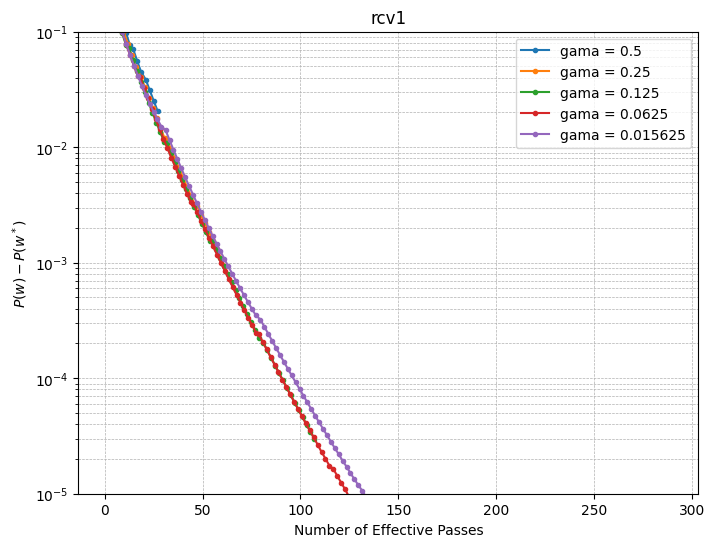

In [47]:
plt.figure(figsize=(8, 6))
for i in range(len(losses_gama)):
  plt.plot(effective_passes_gama[i], loss_residuals_gama[i], label=f"gama = {gama_choice[i]}", marker='o', markersize=3)
plt.xscale("linear")
plt.yscale("log")
plt.xlabel("Number of Effective Passes")
plt.ylabel("$P(w) - P(w^*)$")
plt.title("rcv1")
plt.legend()
plt.ylim(1e-5, 1e-1)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
# plt.savefig('/content/sarah_plus.png')
plt.show()

In [45]:
from google.colab import files
files.download('/content/sarah_plus.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>